# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [112]:
import requests, re
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from numpy import array

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("seaborn")

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob




In [113]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [114]:
df = pd.DataFrame()
df["reviews"] = reviews
df

,reviews
0,✅ Trip Verified | I was flying to Warsaw for ...
1,✅ Trip Verified | Booked a BA holiday to Marr...
2,✅ Trip Verified | Extremely sub-par service. H...
3,✅ Trip Verified | I virtually gave up on Brit...
4,✅ Trip Verified | I was pleasantly surprised ...
...,...
995,✅ Trip Verified | Bangkok to London. The wors...
996,✅ Trip Verified | Food on this 4+ hours flight...
997,✅ Trip Verified | Flew London Heathrow to Delh...
998,Two regular an uneventful flights. Curiously e...


In [115]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

### Data Preprocessing

In [116]:
def filtering_text(data):
    clean_list = []
    for text in data:
        clean = re.sub(r'✅ Trip Verified | ', ' ', text, flags=re.MULTILINE)
        clean = re.sub(r'Not Verified | ', ' ', clean)
        clean = re.sub(r'[^\x00-\x7f]', r'', clean)
        clean = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', clean)
        clean = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", clean)
        clean = re.sub(r'\\u\w\w\w\w', '', clean)
        clean = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ", clean)
        clean = clean.strip()
        clean_list.append(clean)
        
    return clean_list

In [117]:
# Setting up the stop-words
stop_words = stopwords.words("english")

In [118]:
nlp = spacy.load("en_core_web_sm")

In [119]:
def lemmatization_text(text): # text
    rev_text = nlp(text)
    # Extract lemmatized words in lower case format if not digits, not punctuation, not stopword, and length not less than 2
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in stop_words and not token.is_punct and len(token.text) > 3])
    
    return rev_text

In [120]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'
    


In [121]:
%%time
# Applying the function on the reviews 

df["sentiment"] = df["reviews"].apply(get_sentiment)
df["clean_reviews"] = filtering_text(df["reviews"])
df["clean_reviews"] = df["clean_reviews"].apply(lemmatization_text)

df

CPU times: total: 1min 3s
Wall time: 1min 25s


,reviews,sentiment,clean_reviews
0,✅ Trip Verified | I was flying to Warsaw for ...,negative,"[fly, warsaw, meeting, fly, miami, initially, ..."
1,✅ Trip Verified | Booked a BA holiday to Marr...,positive,"[book, holiday, marrakech, post, negative, rev..."
2,✅ Trip Verified | Extremely sub-par service. H...,negative,"[extremely, service, highlights, online, meal,..."
3,✅ Trip Verified | I virtually gave up on Brit...,positive,"[virtually, give, british, airways, year, writ..."
4,✅ Trip Verified | I was pleasantly surprised ...,positive,"[pleasantly, surprised, airline, maintain, ste..."
...,...,...,...
995,✅ Trip Verified | Bangkok to London. The wors...,negative,"[bangkok, london, bad, long, haul, carrier, fl..."
996,✅ Trip Verified | Food on this 4+ hours flight...,positive,"[food, hour, flight, moscow, heathrow, fill, r..."
997,✅ Trip Verified | Flew London Heathrow to Delh...,positive,"[flew, london, heathrow, delhi, airport, termi..."
998,Two regular an uneventful flights. Curiously e...,positive,"[regular, uneventful, flight, curiously, exact..."


In [122]:
df["reviews"]

0      ✅ Trip Verified |  I was flying to Warsaw for ...
1      ✅ Trip Verified |  Booked a BA holiday to Marr...
2      ✅ Trip Verified | Extremely sub-par service. H...
3      ✅ Trip Verified |  I virtually gave up on Brit...
4      ✅ Trip Verified |  I was pleasantly surprised ...
                             ...                        
995    ✅ Trip Verified |  Bangkok to London. The wors...
996    ✅ Trip Verified | Food on this 4+ hours flight...
997    ✅ Trip Verified | Flew London Heathrow to Delh...
998    Two regular an uneventful flights. Curiously e...
999    ✅ Trip Verified | London to Belfast. Another r...
Name: reviews, Length: 1000, dtype: object

### Text Data Analysis

In [123]:
reviews = [word1 for data in df["reviews"] for word1 in data]

fqdist_reviews = FreqDist(reviews)

most_common_word_reviews = fqdist_reviews.most_common(10)

print(most_common_word_reviews)


[(' ', 150278), ('e', 78295), ('t', 55761), ('a', 52032), ('o', 47881), ('i', 42582), ('n', 42463), ('r', 39362), ('s', 37264), ('h', 30318)]


In [124]:
most_common_word_reviews[:][0]

(' ', 150278)

In [125]:
fq_word_reviews = pd.DataFrame(most_common_word_reviews,index=['flight','seat','service','london','time','good','food','crew','hour','cabin'],columns=['word','total_words'])
fq_word_reviews.drop(columns='word',axis=1,inplace=True)
fq_word_reviews


,total_words
flight,150278
seat,78295
service,55761
london,52032
time,47881
good,42582
food,42463
crew,39362
hour,37264
cabin,30318


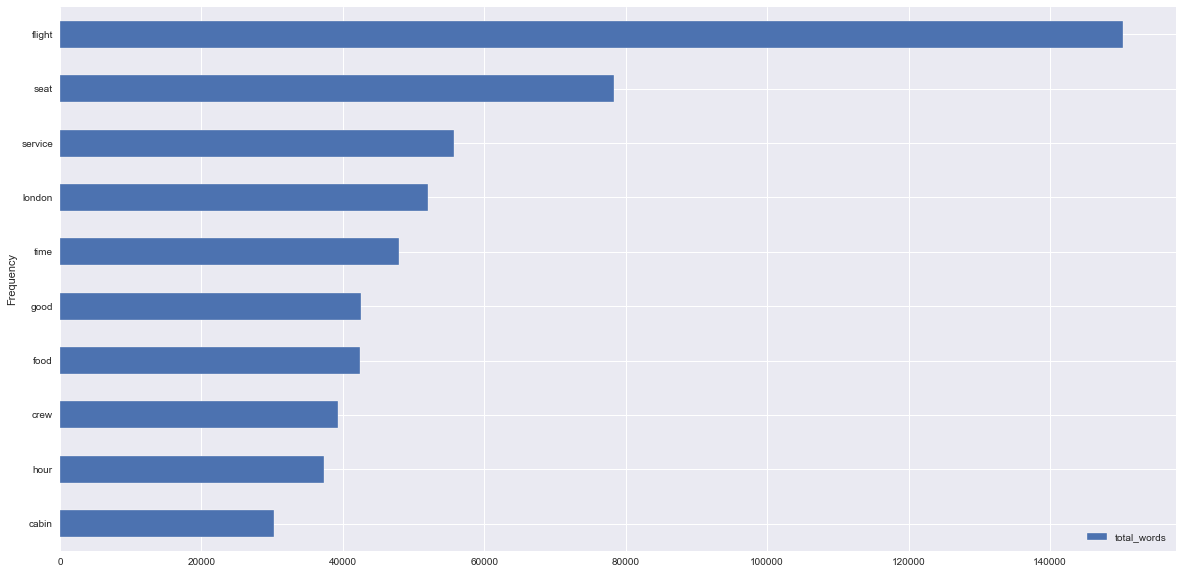

In [126]:
fq_word_reviews.sort_values(by='total_words', ascending=True).plot(kind='barh', figsize=(20, 10))
plt.ylabel('Frequency')
plt.show()

### Sentiment Analysis

C:\Users\Gian\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


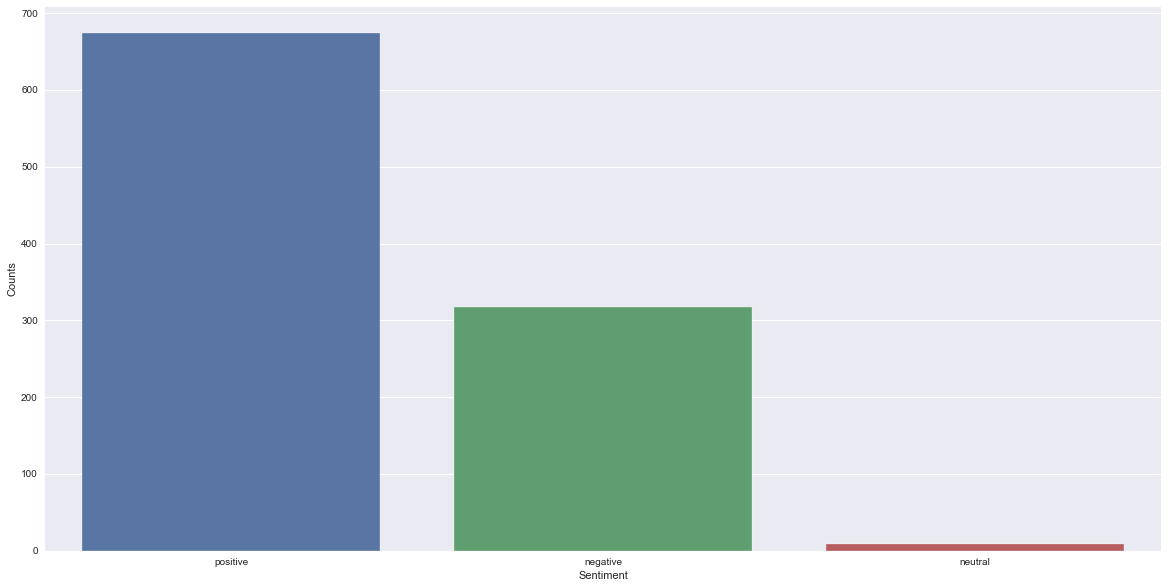

In [127]:
plt.figure(figsize=(20, 10))
sns.barplot(df['sentiment'].value_counts().index,df['sentiment'].value_counts())
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

In [128]:
df['sentiment'].value_counts(normalize=True)*100

positive    67.4
negative    31.7
neutral      0.9
Name: sentiment, dtype: float64

In [129]:
df['sentiment'].value_counts()

positive    674
negative    317
neutral       9
Name: sentiment, dtype: int64